# Scoring & Clustering using Embeddings

-----

This notebook shows how embeddings can be used for scoring and also presents how 
the results can be used for prediction of further downstream constructs, like clusters.
This notebook is used in the setting where the embeddings are computed beforehand 
from another notebook. This can be easily done with the `QuEmbeddings`-object below.

In [ ]:
embd_model = "sbert"
oversample = False
dimreduce = False

## Setup

In [ ]:
import pandas as pd

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

import qutools.data as qtdata
import qutools.clustering as qtclst
import qutools.scoring as qtscore
from qutools.core import ScikitClassifier

In [ ]:
quconfig_path = qtdata.QuConfig.from_yaml("quconfigs/physics-pck.yaml")
quconfig = qtdata.QuConfig.from_yaml(quconfig_path)

qudata = qtdata.QuData(
    quconfig=quconfig,
    df_txt="<NOT IN THIS REPO>/booklets.xlsx",
    df_scr="<NOT IN THIS REPO>/pck-scores.xlsx",
    clip_sparingly_occurring_scores=True
)

quclst = qtclst.QuScoreClusters.from_dir("<NOT IN THIS REPO>/clst-model")
random_state = 42

[99, '99', '', '-', '--', 'NA', 'Na', 'na', 'Null', 'null', ' ', 'nan', 'NaN', 'Nan', 'NAN', nan].
Checked ID-matches. ✓
Validated ID-columns. ✓
Validated text-columns. ✓
Cleaning text-data whitespaces. ✓
All scores in correct ranges. ✓
Validated score-columns. ✓
Found the following score proportions:
	 {0.0: '61.55 %', 1.0: '25.3 %', 2.0: '13.03 %', 3.0: '0.11 %'}
	-> Replacing according to {3.0: 2}
Loading QuData:
---------------
Checked ID-matches. ✓
Validated ID-columns. ✓
Validated text-columns. ✓
Cleaning text-data whitespaces. ✓
All scores in correct ranges. ✓
Validated score-columns. ✓
Scores-Shape: (846, 44)
---------------
Found QuSubscales containing the subscales:
['Reproduzieren', 'Anwenden-Kreieren', 'Analysieren-Evaluieren']
The following exploratory QuScoreClusters-Model has been found:
QuScoreClusters(
	- Config: QuestionnaireConfig(23 text, 4 multiple_choice)
	- Data: text-data: (846, 33) (items-cols) | score-data: (846, 44) (mc_items-cols)
	- Incomplete dropped (<0.5

## Scoring

In [ ]:
ebds_path = f"<NOT IN THIS REPO>//taskwise-{embd_model}.gzip"
df_taskwise_ebds = qtdata.read_data(ebds_path)
df_taskwise_ebds = df_taskwise_ebds.rename(columns={"item": "task"})

In [62]:
qu_tw_ebds = qtdata.QuEmbeddings(
    qudata=qudata,
    embedding_data=df_taskwise_ebds,
)

Info: There are persons/test edits without any valid text-responses, which will not 
	be included in the `.get_txt(...)`-method's result:
	['GR-B2-MZP1-EEA15' 'GR-B2-MZP1-IEE09']


In [63]:
if not dimreduce:
    model = ScikitClassifier()

else:
    kernel = make_pipeline([
        ("dimreduce", PCA(n_components=256)),
        ("model", LogisticRegression(random_state=random_state, C=0.5))
    ])
    model = ScikitClassifier(model=kernel)

	classlabels for new or unseen data might be inappropiate
	and might not even work, depending on the cluster model.


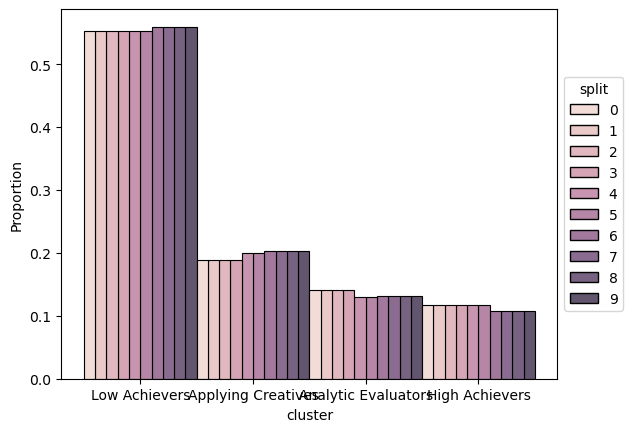

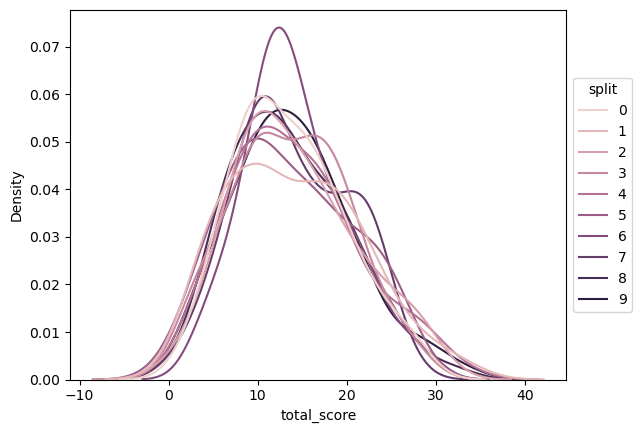

Generatred id-split (n_splits=10, random_state=42, N-test=10) 



100%|██████████| 10/10 [00:01<00:00,  8.18it/s]

You can also call the `to_dir` method on the resulting `QuScorerCVResults`.


In [64]:
quescr = qtscore.QuEmbeddingScorer()
qusr = quescr.random_cross_validate(
    quebds=qu_tw_ebds, 
    quclst=quclst,
    oversample=oversample,
)

In [65]:
qusr.evaluation()

Valid Text Responses Only (test)
 - N-Persons = 844
 - N-Text-tasks = 23
 - N-Responses = 15600
 - Acc = 0.613
 - F1 (weighted) = 0.584
 - F1 (macro) = 0.501
 - Cohens Kappa = 0.249
 - Quadratic Weighted Kappa = 0.379

Scores Larger than possible (test)
 - 56  (i.e., 0.3590 % of all Answer-Score-Pairs)

Evaluation without MC Columns, with Missings Filled (test)
 - N-Persons = 844
 - N-Units = 23
 - N-Responses = 19412
 - Acc = 0.689
 - F1 (weighted) = 0.662
 - F1 (macro) = 0.524
 - Cohens Kappa = 0.302
 - Quadratic Weighted Kappa = 0.428

Multiple-Choice Tasks Scored, Missings Filled (test)
 - N-Persons = 844
 - N-Units = 27
 - N-Responses = 22788
 - Acc = 0.733
 - F1 (weighted) = 0.716
 - F1 (macro) = 0.658
 - Cohens Kappa = 0.463
 - Quadratic Weighted Kappa = 0.624

Multiple Choice as Single Items, Missings Filled (test)
 - N-Persons = 844
 - N-Units = 43
 - N-Responses = 36292
 - Acc = 0.832
 - F1 (weighted) = 0.826
 - F1 (macro) = 0.690
 - Cohens Kappa = 0.680
 - Quadratic Weighted

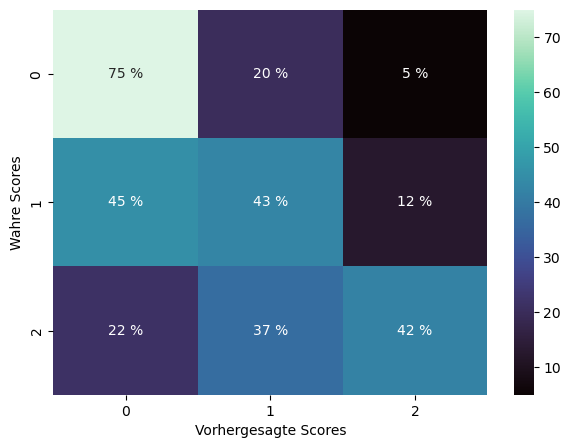

In [32]:
_ = qusr.plot_confusion_matrix()

## Storing Results

In [ ]:
outpath = f"<NOT IN THIS REPO>/{embd_model}"
if oversample:
    outpath += "-oversampled"
if dimreduce:
    outpath += "-dimreduced"

qusr.to_dir(path=outpath, store_qudata=False)

a this object, a directory is needed. Your entered string will be interpreted
as a directory.


## Downstream Clustering

Here, the cross-validation-scoring-results are used for downstream clustering.

In [ ]:
from qutools.scorer_results_classifier import QuScorerResultsClassifier

In [ ]:
qusr_clf = QuScorerResultsClassifier()
qusr_clf_res = qusr_clf.fit(qusr=qusr, targets=quclst, oversample=True)

Using oversampling.
	classlabels for new or unseen data might be inappropiate
	and might not even work, depending on the cluster model.
No `feature_names` passed. Defaulting to ALL columns of `df_scr` apart from the ID-column "ID".


100%|██████████| 10/10 [00:00<00:00, 25.80it/s]


In [ ]:
qusr_clf_res.evaluation()

 - N-Persons = 846
 - Acc = 0.598
 - F1 (weighted) = 0.619
 - F1 (macro) = 0.512
 - Cohens Kappa = 0.399


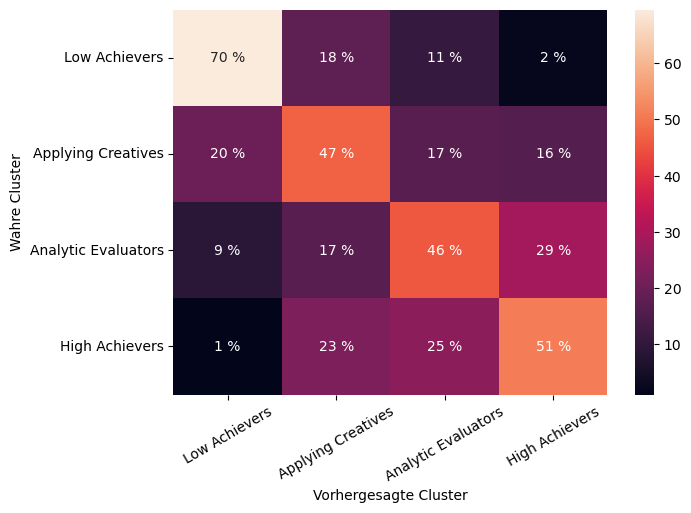

In [ ]:
_ = qusr_clf_res.plot_confusion_matrix()